Iter 0, CFL=0.026, Max u=1.000


/tmp/ipykernel_464/3494852308.py:136: RuntimeWarning: overflow encountered in scalar multiply
  conv = u_ij*dudx + v_ij*dudy
/tmp/ipykernel_464/3494852308.py:136: RuntimeWarning: invalid value encountered in scalar add
  conv = u_ij*dudx + v_ij*dudy
/tmp/ipykernel_464/3494852308.py:159: RuntimeWarning: overflow encountered in scalar multiply
  conv = u_ij*dvdx + v_ij*dvdy
/tmp/ipykernel_464/3494852308.py:159: RuntimeWarning: invalid value encountered in scalar add
  conv = u_ij*dvdx + v_ij*dvdy
/tmp/ipykernel_464/3494852308.py:195: RuntimeWarning: invalid value encountered in scalar subtract
  (self.v[i,j+1] - self.v[i,j])/dy
/tmp/ipykernel_464/3494852308.py:194: RuntimeWarning: invalid value encountered in scalar subtract
  div_u[i,j] = (self.u[i+1,j] - self.u[i,j])/dx + \


Iter 10, CFL=nan, Max u=nan
Iter 20, CFL=nan, Max u=nan
Iter 30, CFL=nan, Max u=nan
Iter 40, CFL=nan, Max u=nan
Iter 50, CFL=nan, Max u=nan
Iter 60, CFL=nan, Max u=nan
Iter 70, CFL=nan, Max u=nan
Iter 80, CFL=nan, Max u=nan
Iter 90, CFL=nan, Max u=nan


ValueError: The rows of 'x' must be equal

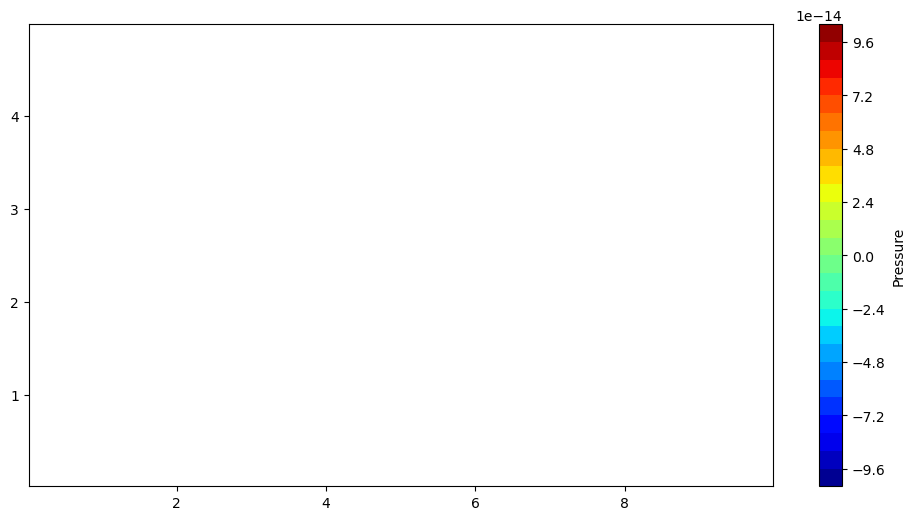

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, linalg
from scipy.sparse.linalg import spsolve


class StaggeredGrid:
    def __init__(self, lx, ly, nx, ny):
        """
        交错网格系统：
        - p存储在单元中心 (nx-1, ny-1)
        - u存储在东侧边中心 (nx, ny-1)
        - v存储在南侧边中心 (nx-1, ny)
        """
        self.lx = lx
        self.ly = ly
        self.nx = nx   # 压力网格x方向数
        self.ny = ny   # 压力网格y方向数
        
        # 压力网格参数 (单元中心)
        self.dx = lx / (nx - 1)
        self.dy = ly / (ny - 1)
        self.x_p = np.linspace(self.dx/2, lx - self.dx/2, nx-1)
        self.y_p = np.linspace(self.dy/2, ly - self.dy/2, ny-1)
        
        # u速度网格参数 (东侧边中心)
        self.x_u = np.linspace(0, lx, nx)
        self.y_u = self.y_p  # 与p网格y对齐
        
        # v速度网格参数 (南侧边中心)
        self.x_v = self.x_p  # 与p网格x对齐
        self.y_v = np.linspace(0, ly, ny)

class Solid:
    def __init__(self, x0, y0, angle, length, thickness):
        self.x0 = x0
        self.y0 = y0
        self.angle = np.radians(angle)
        self.length = length
        self.thickness = thickness

    def get_u_mask(self, grid):
        """为u速度场生成掩膜"""
        mask = np.zeros((grid.nx, grid.ny-1), dtype=bool)
        cos_theta = np.cos(self.angle)
        sin_theta = np.sin(self.angle)
        hl = self.length/2
        ht = self.thickness/2
        
        for i in range(grid.nx):
            for j in range(grid.ny-1):
                x = grid.x_u[i]
                y = (grid.y_p[j] + grid.y_p[j+1])/2 if j < grid.ny-2 else grid.y_p[j]
                dx = x - self.x0
                dy = y - self.y0
                local_x =  dx*cos_theta + dy*sin_theta
                local_y = -dx*sin_theta + dy*cos_theta
                if (-hl <= local_x <= hl) and (-ht <= local_y <= ht):
                    mask[i,j] = True
        return mask

    def get_v_mask(self, grid):
        """为v速度场生成掩膜"""
        mask = np.zeros((grid.nx-1, grid.ny), dtype=bool)
        cos_theta = np.cos(self.angle)
        sin_theta = np.sin(self.angle)
        hl = self.length/2
        ht = self.thickness/2
        
        for i in range(grid.nx-1):
            for j in range(grid.ny):
                x = (grid.x_p[i] + grid.x_p[i+1])/2 if i < grid.nx-2 else grid.x_p[i]
                y = grid.y_v[j]
                dx = x - self.x0
                dy = y - self.y0
                local_x =  dx*cos_theta + dy*sin_theta
                local_y = -dx*sin_theta + dy*cos_theta
                if (-hl <= local_x <= hl) and (-ht <= local_y <= ht):
                    mask[i,j] = True
        return mask

class FluidSolver:
    def __init__(self, grid):
        self.grid = grid
        # 速度场初始化（注意维度）
        self.u = np.zeros((grid.nx, grid.ny-1))   # (nx x ny-1)
        self.v = np.zeros((grid.nx-1, grid.ny))   # (nx-1 x ny)
        # 压力场初始化
        self.p = np.zeros((grid.nx-1, grid.ny-1)) # (nx-1 x ny-1)
        self.residuals = []

    def apply_velocity_bc(self):
        # 入口边界条件 (左边界)
        self.u[0, :] = 1.0  
        self.v[0, :] = 0.0

        # 出口边界条件 (右边界)
        self.u[-1, :] = self.u[-2, :]
        self.v[-1, :] = self.v[-2, :]

        # 上下壁面：滑移壁面
        self.v[:, 0] = 0.0         # 下边界，垂直速度为0
        self.v[:, -1] = 0.0        # 上边界，垂直速度为0

        self.u[:, 0] = self.u[:, 1]     # 水平方向速度：Neumann边界（∂u/∂y = 0）
        self.u[:, -1] = self.u[:, -2]

    def solve_momentum(self, dt):
        # 动量预测步（显式）
        u_star = self.u.copy()
        v_star = self.v.copy()
        dx, dy = self.grid.dx, self.grid.dy
        
        # 更新u动量方程
        for i in range(1, self.grid.nx-1):
            for j in range(1, self.grid.ny-2):  # u的有效y范围
                # 压力梯度项（使用相邻压力节点）
                dpdx = (self.p[i, j] - self.p[i-1, j]) / dx
                
                # 对流项（迎风格式）
                u_ij = 0.5*(self.u[i,j] + self.u[i-1,j])
                v_ij = 0.5*(self.v[i-1,j+1] + self.v[i,j+1])
                
                # x方向对流
                if u_ij > 0:
                    dudx = (self.u[i,j] - self.u[i-1,j])/dx
                else:
                    dudx = (self.u[i+1,j] - self.u[i,j])/dx
                
                # y方向对流
                if v_ij > 0:
                    dudy = (self.u[i,j] - self.u[i,j-1])/dy
                else:
                    dudy = (self.u[i,j+1] - self.u[i,j])/dy
                
                conv = u_ij*dudx + v_ij*dudy
                u_star[i,j] = self.u[i,j] + dt*(-dpdx - conv)
        
        # 更新v动量方程（类似处理）
        for i in range(1, self.grid.nx-2):
            for j in range(1, self.grid.ny-1):
                dpdy = (self.p[i, j] - self.p[i, j-1]) / dy
                
                u_ij = 0.5*(self.u[i+1,j-1] + self.u[i+1,j])
                v_ij = 0.5*(self.v[i,j] + self.v[i,j-1])
                
                # x方向对流
                if u_ij > 0:
                    dvdx = (self.v[i,j] - self.v[i-1,j])/dx
                else:
                    dvdx = (self.v[i+1,j] - self.v[i,j])/dx
                
                # y方向对流
                if v_ij > 0:
                    dvdy = (self.v[i,j] - self.v[i,j-1])/dy
                else:
                    dvdy = (self.v[i,j+1] - self.v[i,j])/dy
                
                conv = u_ij*dvdx + v_ij*dvdy
                v_star[i,j] = self.v[i,j] + dt*(-dpdy - conv)
                
        self.u, self.v = u_star, v_star



    def build_poisson_matrix(self):
        """构建压力泊松方程的系数矩阵"""
        nx, ny = self.grid.nx-1, self.grid.ny-1  # 压力网格维度
        N = nx * ny
        dx, dy = self.grid.dx, self.grid.dy
        
        # 主对角线
        main_diag = -2*(1/dx**2 + 1/dy**2) * np.ones(N)
        
        # x方向相邻
        x_diag = (1/dx**2) * np.ones(N-1)
        x_diag[::ny] = 0  # 排除边界
        
        # y方向相邻
        y_diag = (1/dy**2) * np.ones(N-nx)
        
        A = diags([main_diag, x_diag, x_diag, y_diag, y_diag],
                  [0, 1, -1, nx, -nx])
        return A.tocsr()

    def solve_pressure_correction(self, dt):
        dx, dy = self.grid.dx, self.grid.dy
        nx, ny = self.grid.nx-1, self.grid.ny-1
        
        # 计算散度场
        div_u = np.zeros((nx, ny))
        for i in range(nx):
            for j in range(ny):
                div_u[i,j] = (self.u[i+1,j] - self.u[i,j])/dx + \
                             (self.v[i,j+1] - self.v[i,j])/dy
        
        # 构建线性系统
        A = self.build_poisson_matrix()
        b = div_u.flatten() / dt
        
        # 求解压力修正
        p_corr = spsolve(A, b).reshape(nx, ny)
        return p_corr

    def correct_fields(self, p_corr, dt):
        dx, dy = self.grid.dx, self.grid.dy
        
        # 压力修正
        self.p += p_corr
        
        # 速度修正
        # 修正u速度
        for i in range(1, self.grid.nx-1):
            for j in range(self.grid.ny-1):
                self.u[i,j] -= dt * (p_corr[i,j] - p_corr[i-1,j])/dx
                
        # 修正v速度
        for i in range(self.grid.nx-1):
            for j in range(1, self.grid.ny-1):
                self.v[i,j] -= dt * (p_corr[i,j] - p_corr[i,j-1])/dy
    
    def compute_cfl(self, dt):
        dx, dy = self.grid.dx, self.grid.dy
        cfl_u = np.max(np.abs(self.u)) * dt / dx
        cfl_v = np.max(np.abs(self.v)) * dt / dy
        return max(cfl_u, cfl_v)


class IBM:
    def __init__(self, grid, solid):
        self.grid = grid
        self.solid = solid
        self.u_mask = solid.get_u_mask(grid)
        self.v_mask = solid.get_v_mask(grid)
        
    def enforce_boundary(self, u, v):
        u[self.u_mask] = 0.0
        v[self.v_mask] = 0.0
        return u, v

def main():
    grid = StaggeredGrid(lx=10.0, ly=5.0, nx=256, ny=128)
    solid = Solid(x0=5.0, y0=2.5, angle=30, length=1.0, thickness=0.1)
    solver = FluidSolver(grid)
    #ibm = IBM(grid, solid)
    
    dt = 0.001
    max_iter = 100
    
    for iter in range(max_iter):
        solver.apply_velocity_bc()
        solver.solve_momentum(dt)
        p_corr = solver.solve_pressure_correction(dt)
        solver.correct_fields(p_corr, dt)
        #solver.u, solver.v = ibm.enforce_boundary(solver.u, solver.v)
        
        if iter % 10 == 0:
            cfl = solver.compute_cfl(dt)
            print(f"Iter {iter}, CFL={cfl:.3f}, Max u={np.max(solver.u):.3f}")

    # 可视化（将速度插值到压力网格）
    u_center = 0.5*(solver.u[:-1, :] + solver.u[1:, :])
    v_center = 0.5*(solver.v[:, :-1] + solver.v[:, 1:])
    
    X, Y = np.meshgrid(grid.x_p, grid.y_p, indexing='ij')
    plt.figure(figsize=(12,6))
    plt.contourf(X, Y, solver.p, levels=32, cmap='jet')
    plt.colorbar(label='Pressure')
    plt.streamplot(X, Y, u_center, v_center, color='w', density=1.5)
    plt.title('Staggered Grid Simulation Results')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

if __name__ == "__main__":
    main()

